In [2]:
import os
import yaml
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
with open('../../data/post_test/rankings_scored.pkl', 'rb') as fp:
    rankings = pickle.load(fp)
    
with open('../../data/experiment_keys/permutation_maps/vector_binary.yaml', 'r') as fp:
    permutation_map = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../visualisers/maps/concat_labels.yaml', 'r') as fp:
    palette = yaml.load(fp, Loader=yaml.FullLoader)
    palette = palette['vector_labels']
    palette['q1'] = '#8AB0AB'
    palette['q2'] = '#3E505B'
    palette['q3'] = '#F2F230'
    palette['q4'] = '#1A1D1A'

In [4]:
rankings_columns = [
    'username', 'field', 'level', 'year', 'consent', 'gender', 
    'prior_knowledge', 'prior_3cat', 'prior_4cat',
    'ranking', 'q1_conf', 'q2_conf', 'q3_conf', 'q4_conf', 
    'q5_colour0', 'q5_colour1', 'q5_colour2', 'q5_colour3',
    'q6_colour0', 'q6_colour1', 'q6_colour2', 'q6_colour3',
    'notes_text', 'notes_math', 'notes_table', 'notes_diag', 'notes_time', 
    'beerslaw', 'beerslaw_conf', 
    'feedback_entertain', 'feedback_difficult', 'feedback_good', 'feedback_bad', 'feedback',
    'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'q5_score_conf', 'q6_score', 'q6_score_conf',
]

ranks = rankings[rankings_columns]
ranks['vector_label'] = ranks['ranking'].apply(lambda x: permutation_map['map'][x])
ranks['prior_3cat'] = ranks['prior_3cat'].apply(lambda x: str(x.split(',')[0]))
ranks['prior_4cat'] = ranks['prior_4cat'].apply(lambda x: str(x.split(',')[0]))
ranks = ranks[ranks['q5_colour0'] != 'missing']
ranks = ranks[ranks['q6_colour0'] != 'missing']

# Prior Levels

In [5]:
def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_knowledge_prior(df, category, prior:str, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    subdf = get_sub_df(df, category, prior)
    subdf['plot_score'] = subdf['q1_score'] + subdf['q2_score'] + subdf['q3_score'] + subdf['q4_score'] + subdf['q5_score'] + subdf['q6_score']
    subdf['plot_confidence'] = subdf['q1_conf'].astype(int) + subdf['q2_conf'].astype(int) + subdf['q3_conf'].astype(int) + subdf['q4_conf'].astype(int) + subdf['q5_colour1'].astype(int) + subdf['q6_colour1'].astype(int)
    subdf['plot_confidence'] = subdf['plot_confidence'].apply(lambda x: float(x)/6)
    
    # scores
    scores = subdf['plot_score'].unique()
    scores.sort()
    
    x = []
    y = []
    confidences = []
    for i, score in enumerate(scores):
        x.append(i + 1)
        subsub = get_sub_df(subdf, 'plot_score', score)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=[palette[key] for key in palette][0:len(y)])
    # confidence boxplot
#     axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x) +1))
    axis.set_xticklabels([xx-1 for xx in x])
    axis.set_title('Level of knowledge: ' + prior + '  [#' + str(len(subdf)) + ' students]')
    axis.set_ylim([0, 60])
    

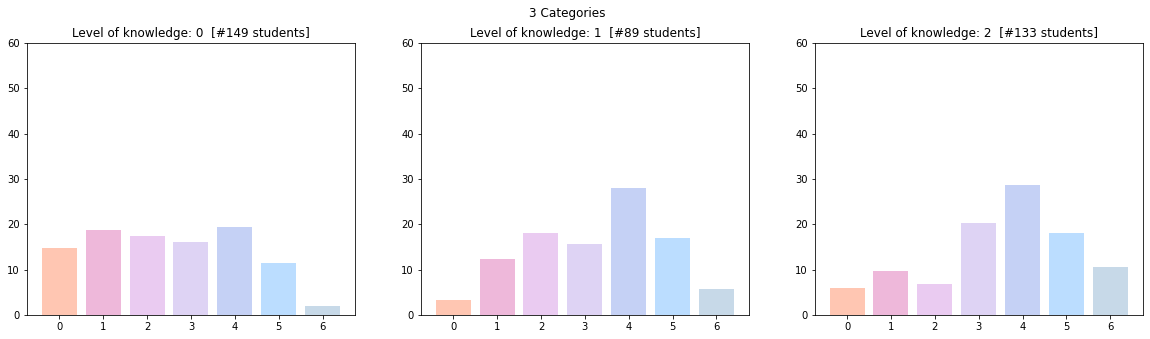

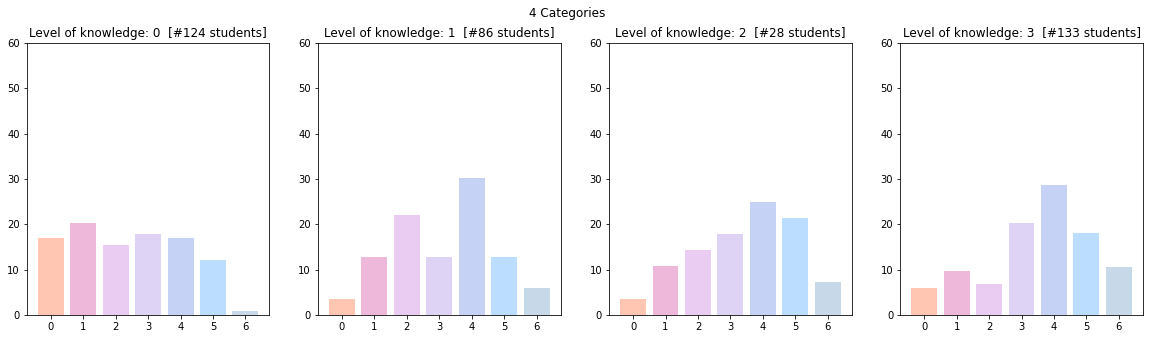

In [8]:
# 3 Categories
fig, axis = plt.subplots(1, 3, figsize=(20, 5))

plot_boxplot_knowledge_prior(ranks, 'prior_3cat', '0', axis[0])
plot_boxplot_knowledge_prior(ranks, 'prior_3cat', '1', axis[1])
plot_boxplot_knowledge_prior(ranks, 'prior_3cat', '2', axis[2])
plt.suptitle('3 Categories')
plt.show()

# 4 Categories
fig, axis = plt.subplots(1, 4, figsize=(20, 5))

plot_boxplot_knowledge_prior(ranks, 'prior_4cat', '0', axis[0])
plot_boxplot_knowledge_prior(ranks, 'prior_4cat', '1', axis[1])
plot_boxplot_knowledge_prior(ranks, 'prior_4cat', '2', axis[2])
plot_boxplot_knowledge_prior(ranks, 'prior_4cat', '3', axis[3])
plt.suptitle('4 Categories')
plt.show()

# Scores

## Scores to Prior

In [13]:
def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_score_to_prior(df, category, score:int, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    df['plot_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score'] + df['q5_score'] + df['q6_score']
    df['plot_confidence'] = df['q1_conf'].astype(int) + df['q2_conf'].astype(int) + df['q3_conf'].astype(int) + df['q4_conf'].astype(int) + df['q5_colour1'].astype(int) + df['q6_colour1'].astype(int)
    df['plot_confidence'] = df['plot_confidence'].apply(lambda x: float(x)/6)
    subdf = get_sub_df(df, 'plot_score', score)
    
    # prior knowledge
    priors = subdf[category].unique()
    priors = [p for p in priors if p in ['0', '1', '2', '3']]
    priors = [int(p) for p in priors]
    priors.sort()
    priors = [str(p) for p in priors]
    label_priors = [category_map[p] for p in priors]
    
    x = []
    y = []
    confidences = []
    for i, p in enumerate(priors):
        x.append(i + 1)
        subsub = get_sub_df(subdf, category, p)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=[palette[key] for key in palette][0:len(y)])
    # confidence boxplot
    axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x)+1))
    axis.set_xticklabels(label_priors)
    axis.set_ylim([0, 100])
    axis.set_title('Score ' + str(score) + '   [#' + str(len(subdf)) + ' students]')
    

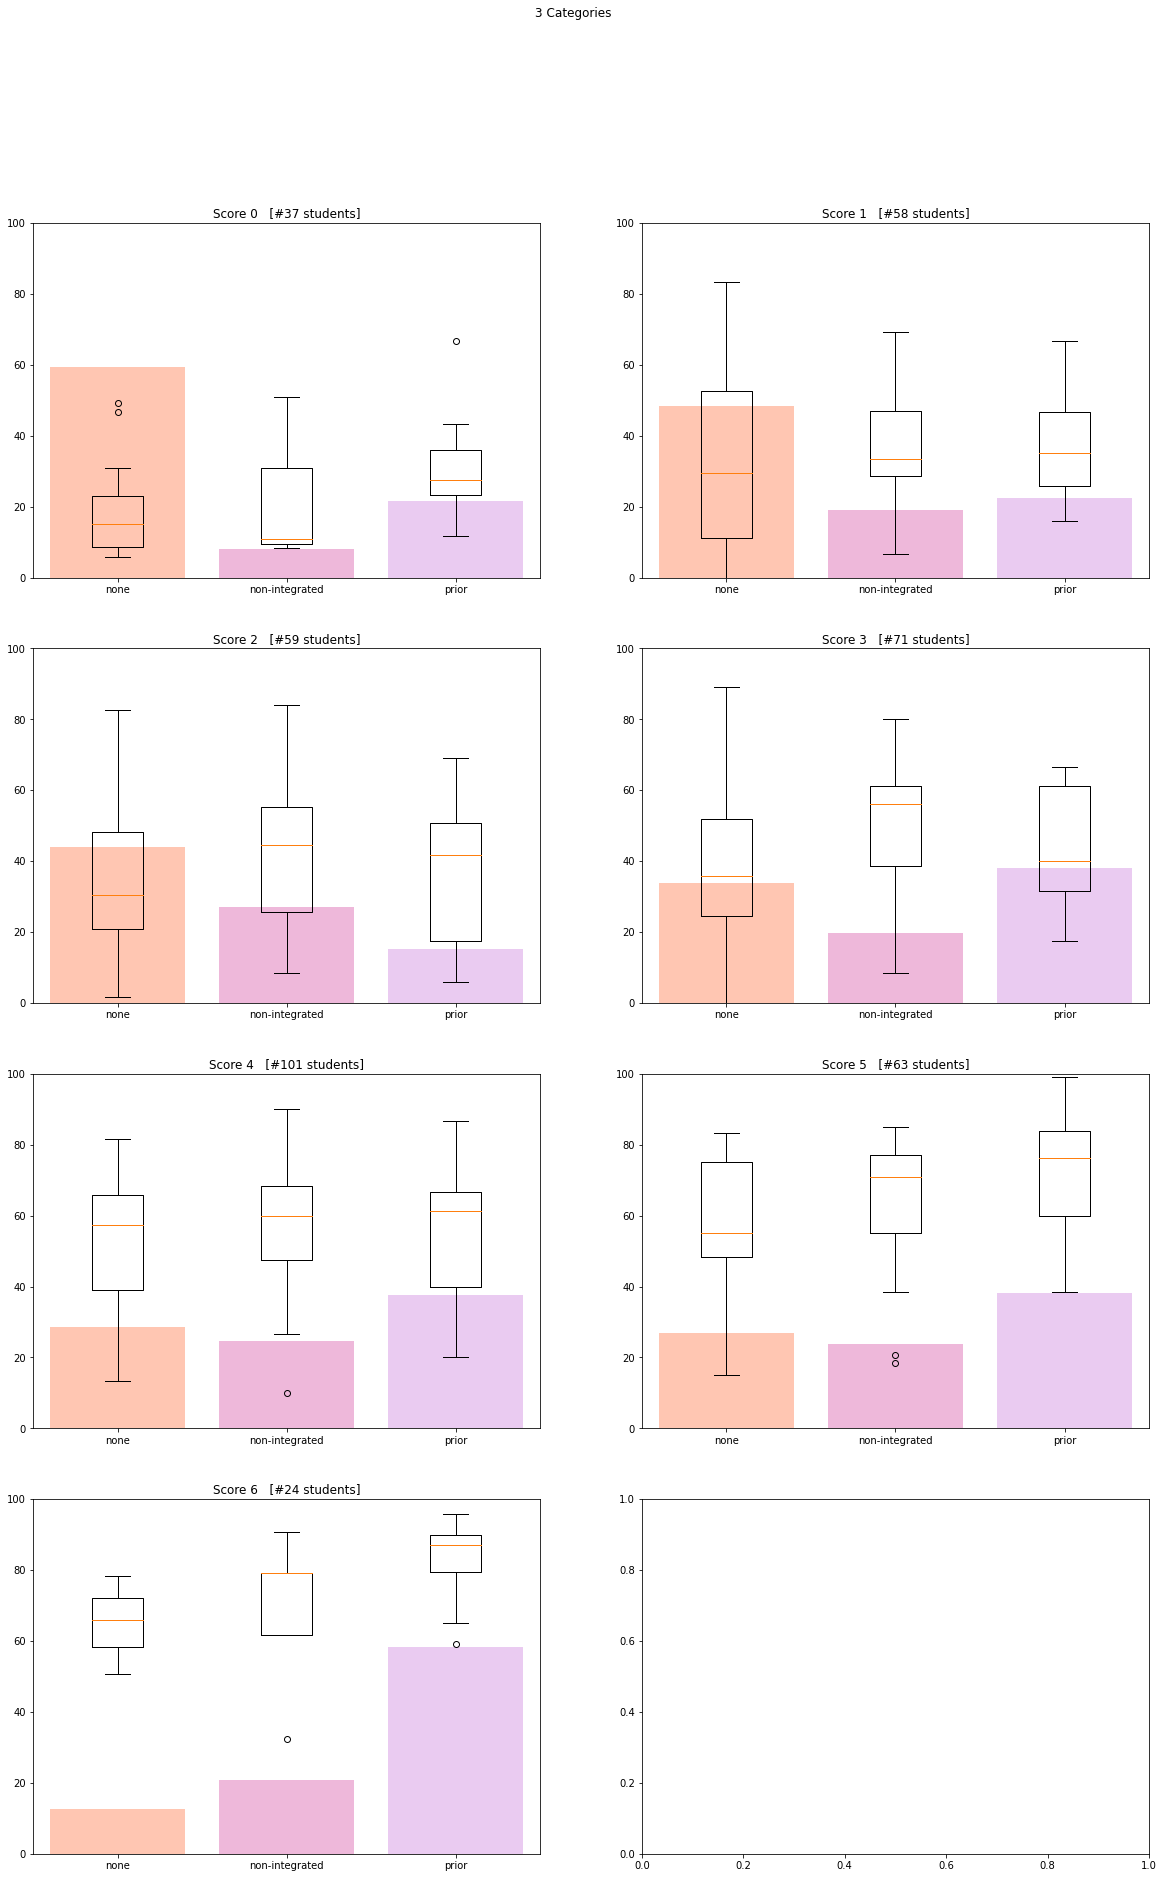

In [14]:
category_map = {
    '0': 'none',
    '1': 'non-integrated',
    '2': 'prior'
}


fig, axis = plt.subplots(4, 2, figsize=(20, 30))

plot_boxplot_score_to_prior(ranks, 'prior_3cat', 0, axis[0, 0])
plot_boxplot_score_to_prior(ranks, 'prior_3cat', 1, axis[0, 1])
plot_boxplot_score_to_prior(ranks, 'prior_3cat', 2, axis[1, 0])
plot_boxplot_score_to_prior(ranks, 'prior_3cat', 3, axis[1, 1])
plot_boxplot_score_to_prior(ranks, 'prior_3cat', 4, axis[2, 0])
plot_boxplot_score_to_prior(ranks, 'prior_3cat', 5, axis[2, 1])
plot_boxplot_score_to_prior(ranks, 'prior_3cat', 6, axis[3, 0])
plt.suptitle("3 Categories")
plt.show()

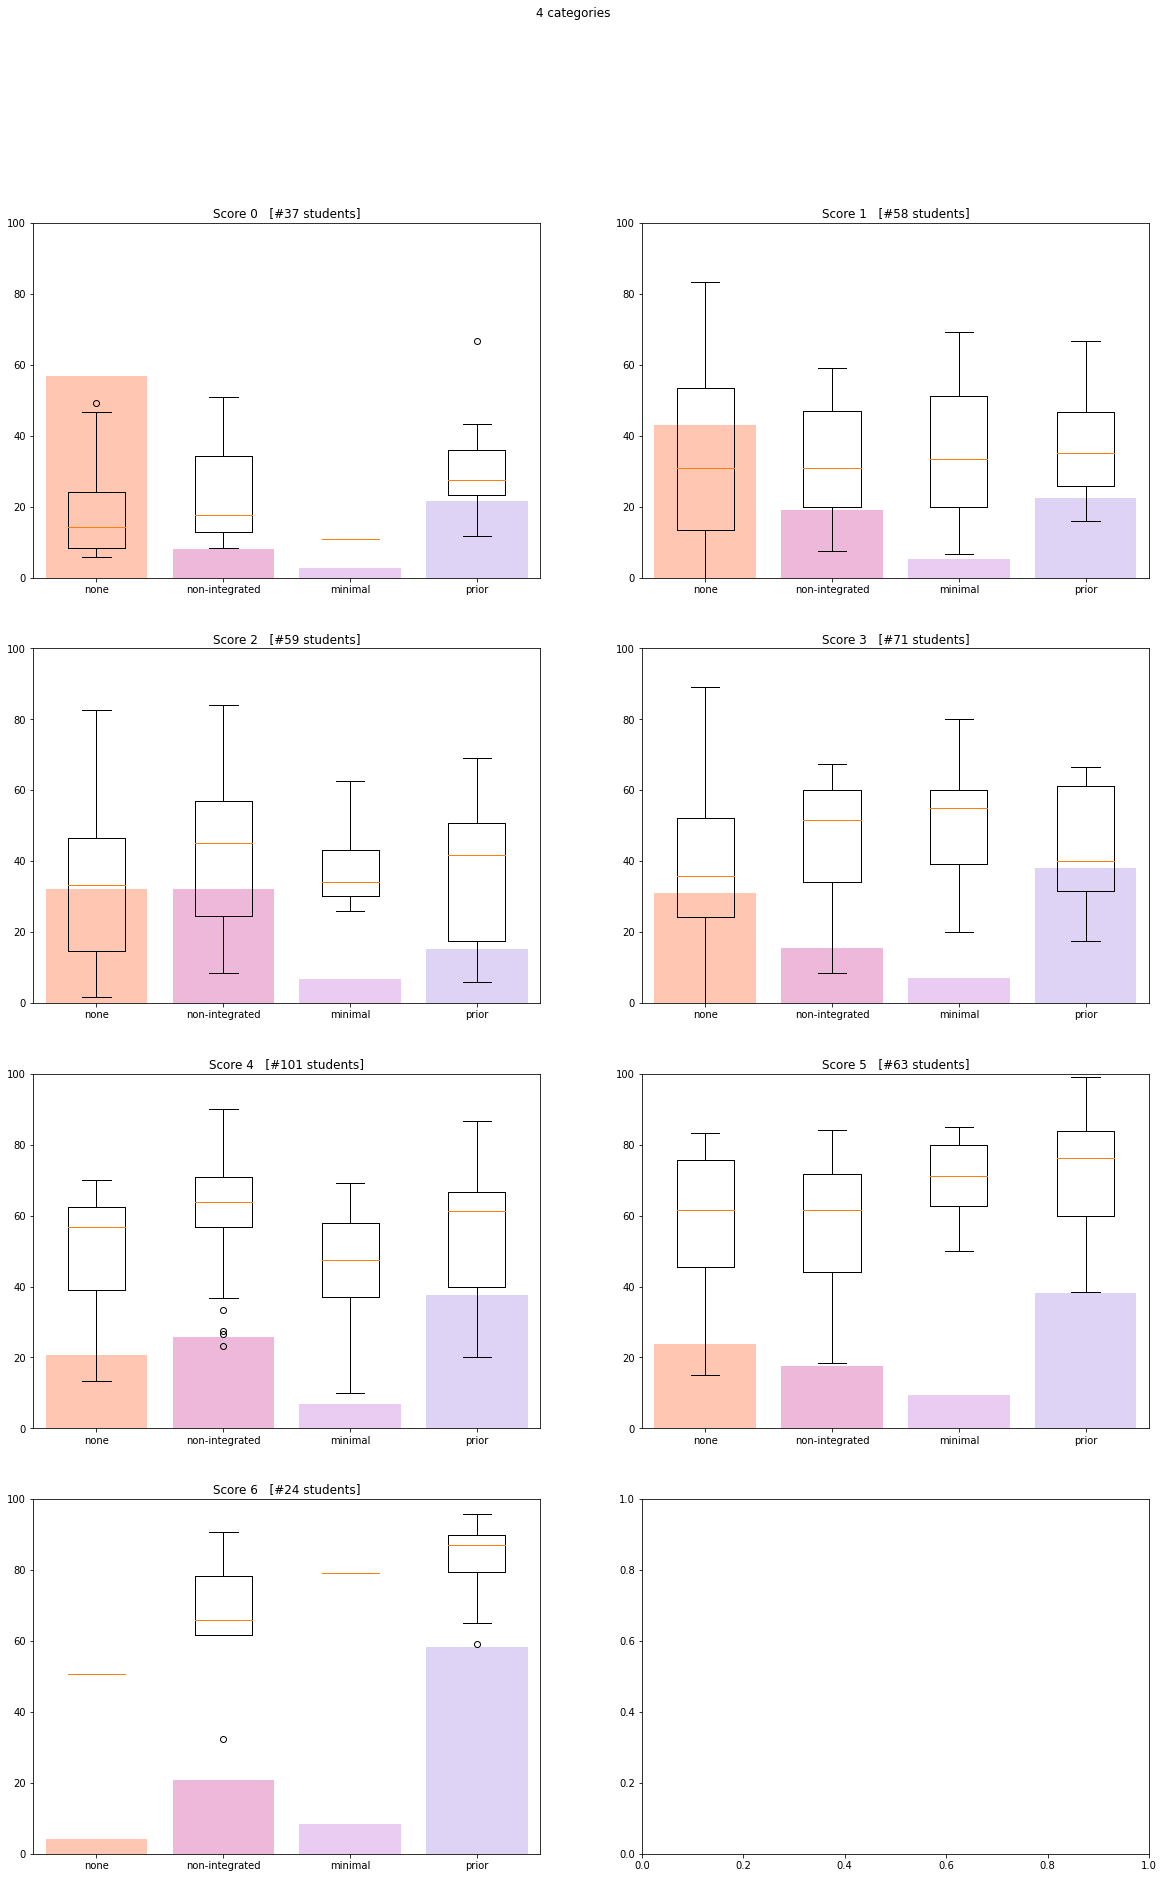

In [15]:
category_map = {
    '0': 'none',
    '1': 'non-integrated',
    '2': 'minimal',
    '3': 'prior'
}


fig, axis = plt.subplots(4, 2, figsize=(20, 30))

plot_boxplot_score_to_prior(ranks, 'prior_4cat', 0, axis[0, 0])
plot_boxplot_score_to_prior(ranks, 'prior_4cat', 1, axis[0, 1])
plot_boxplot_score_to_prior(ranks, 'prior_4cat', 2, axis[1, 0])
plot_boxplot_score_to_prior(ranks, 'prior_4cat', 3, axis[1, 1])
plot_boxplot_score_to_prior(ranks, 'prior_4cat', 4, axis[2, 0])
plot_boxplot_score_to_prior(ranks, 'prior_4cat', 5, axis[2, 1])
plot_boxplot_score_to_prior(ranks, 'prior_4cat', 6, axis[3, 0])
plt.suptitle('4 categories')
plt.show()

## Scores to rankings

In [33]:
category_map = {
    '0': 'none',
    '1': 'non-integrated',
    '2': 'minimum',
    '3': 'prior'
}

def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_score_to_ranking(df, category: str, score:int, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    df['plot_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score'] + df['q5_score'] + df['q6_score']
    df['plot_confidence'] = df['q1_conf'].astype(int) + df['q2_conf'].astype(int) + df['q3_conf'].astype(int) + df['q4_conf'].astype(int) + df['q5_colour1'].astype(int) + df['q6_colour1'].astype(int)
    df['plot_confidence'] = df['plot_confidence'].apply(lambda x: float(x)/6)
    subdf = get_sub_df(df, 'plot_score', score)
    
    # rankings
    rankings = subdf['ranking'].unique()
    rankings_labels = [permutation_map['map'][r] for r in rankings]
    colours = [permutation_map['map'][r] for r in rankings]
    colours = [palette[c] for c in colours]
    indices = [(int(s[0]) + int(s[1]) + int(s[2])) for s in rankings_labels]
    indices = np.argsort(indices)
    rankings = [rankings[idx] for idx in indices]
    colours = [colours[idx] for idx in indices]
    rankings_labels = [rankings_labels[idx] for idx in indices]
    
    x = []
    y = []
    confidences = []
    for i, r in enumerate(rankings):
        x.append(i + 1)
        subsub = get_sub_df(subdf, 'ranking', r)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=colours)
    # confidence boxplot
    axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x)+1))
    axis.set_xticklabels(rankings)
    axis.set_ylim([0, 100])
    axis.set_title('Score ' + str(score) + ' [#' + str(len(subdf)) + '  students]')
    

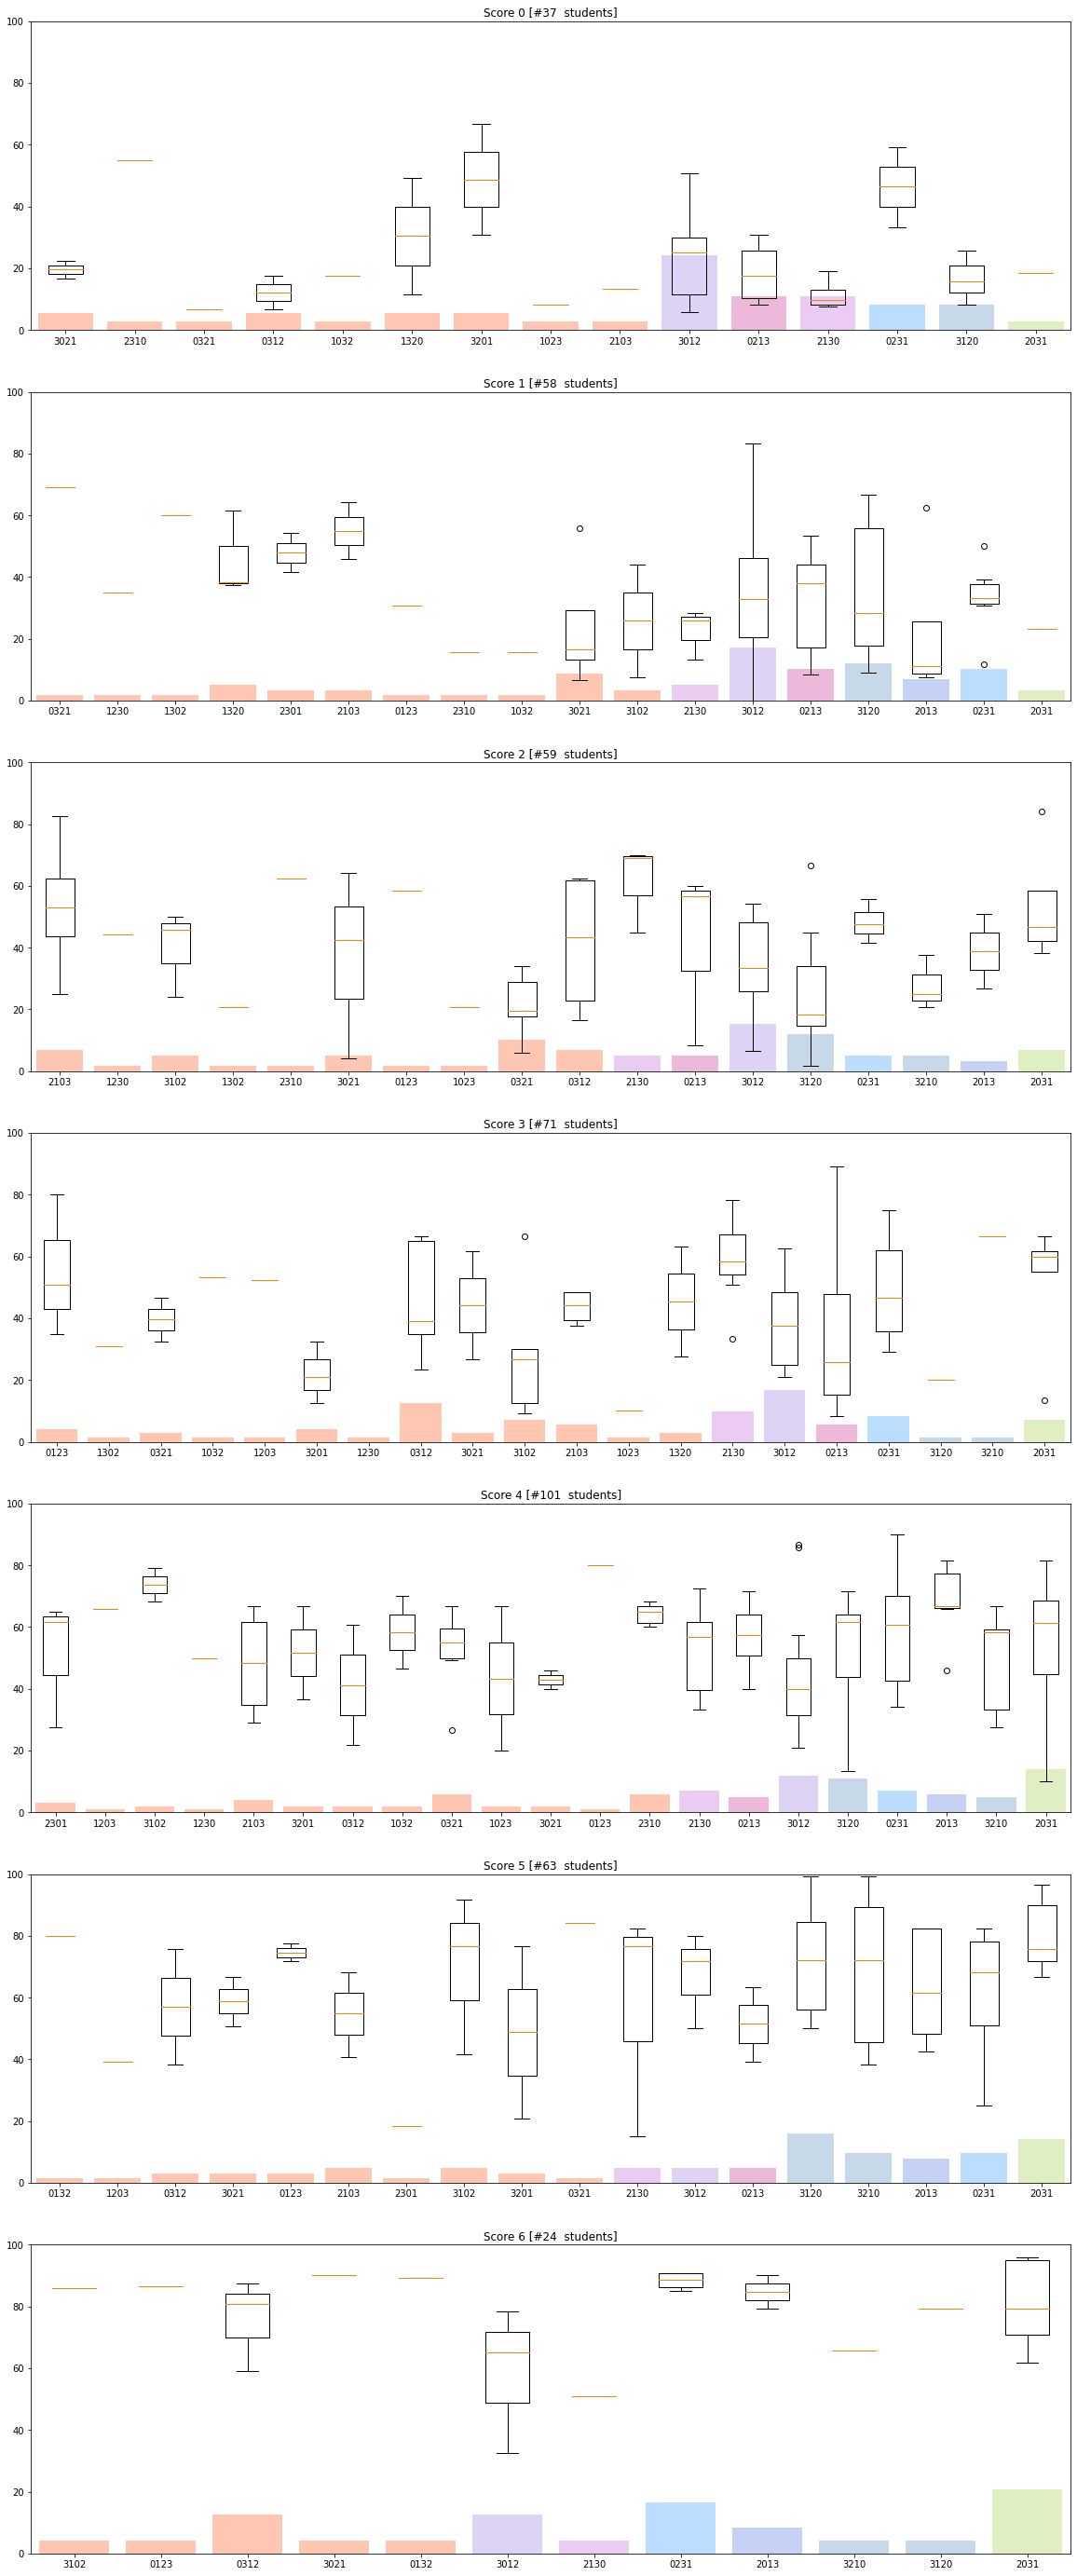

In [34]:
fig, axis = plt.subplots(7, 1, figsize=(20, 50))

plot_boxplot_score_to_ranking(ranks, 0, axis[0])
plot_boxplot_score_to_ranking(ranks, 1, axis[1])
plot_boxplot_score_to_ranking(ranks, 2, axis[2])
plot_boxplot_score_to_ranking(ranks, 3, axis[3])
plot_boxplot_score_to_ranking(ranks, 4, axis[4])
plot_boxplot_score_to_ranking(ranks, 5, axis[5])
plot_boxplot_score_to_ranking(ranks, 6, axis[6])

## Scores to vector labels

In [35]:
category_map = {
    '0': 'none',
    '1': 'non-integrated',
    '2': 'minimum',
    '3': 'prior'
}

def get_sub_df(df, attribute:str, label):
    """
    returns the part of the dataframe who's attribute *attribute* is *label*
    """
    return df[df[attribute] == label]

def plot_boxplot_score_to_permutationmap(df, score:int, axis):
    """
    Make distribution of score + confidence boxplot for each score for prior knowledge level *prior*, for group
    with attribute *attribute*
    """
    df['plot_score'] = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score'] + df['q5_score'] + df['q6_score']
    df['plot_confidence'] = df['q1_conf'].astype(int) + df['q2_conf'].astype(int) + df['q3_conf'].astype(int) + df['q4_conf'].astype(int) + df['q5_colour1'].astype(int) + df['q6_colour1'].astype(int)
    df['plot_confidence'] = df['plot_confidence'].apply(lambda x: float(x)/6)
    subdf = get_sub_df(df, 'plot_score', score)
    
    # rankings
    rankings = subdf['ranking'].unique()
    rankings_labels = [permutation_map['map'][r] for r in rankings]
    colours = [permutation_map['map'][r] for r in rankings]
    colours = [palette[c] for c in colours]
    indices = [(int(s[0]) + int(s[1]) + int(s[2])) for s in rankings_labels]
    indices = np.argsort(indices)
    rankings = [rankings[idx] for idx in indices]
    colours = [colours[idx] for idx in indices]
    rankings_labels = [rankings_labels[idx] for idx in indices]
    
    x = []
    y = []
    confidences = []
    for i, r in enumerate(rankings):
        x.append(i + 1)
        subsub = get_sub_df(subdf, 'ranking', r)
        height = len(subsub)*100/len(subdf)
        y.append(height)
        conf = confidences.append(subsub['plot_confidence'])
    
    
    # score distribution
    axis.bar(x, y, alpha=0.3, color=colours)
    # confidence boxplot
    axis.boxplot(confidences)
    
    #aesthetic
    axis.set_xticks(range(1, len(x)+1))
    axis.set_xticklabels(rankings_labels)
    axis.set_ylim([0, 100])
    axis.set_title('Score ' + str(score) + '   [#' + str(len(subdf)) + ' students]')
    

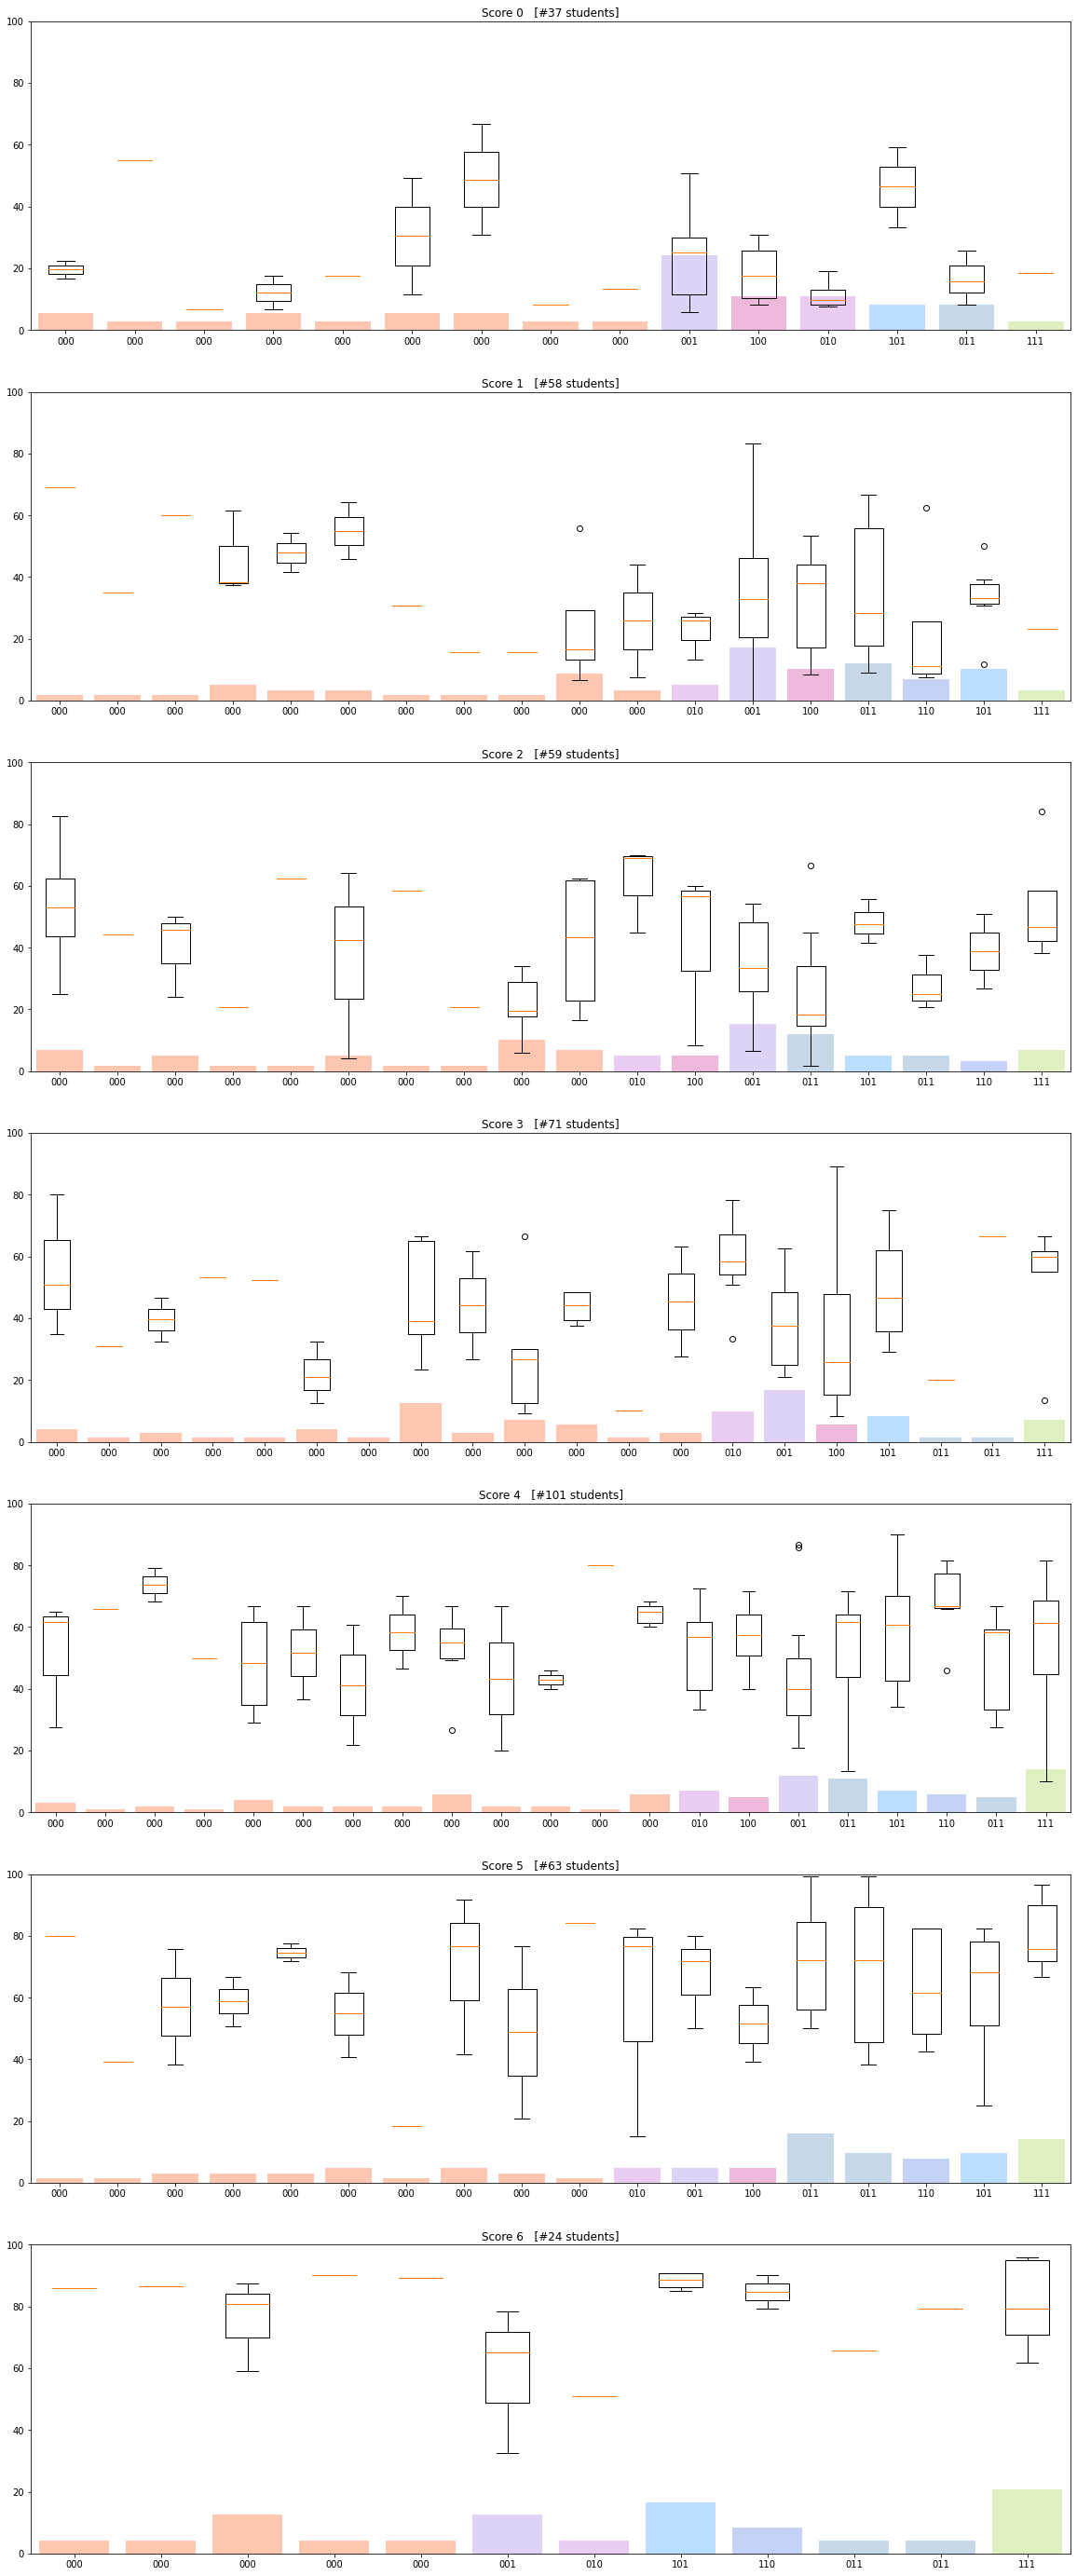

In [36]:
fig, axis = plt.subplots(7, 1, figsize=(20, 50))

plot_boxplot_score_to_permutationmap(ranks, 0, axis[0])
plot_boxplot_score_to_permutationmap(ranks, 1, axis[1])
plot_boxplot_score_to_permutationmap(ranks, 2, axis[2])
plot_boxplot_score_to_permutationmap(ranks, 3, axis[3])
plot_boxplot_score_to_permutationmap(ranks, 4, axis[4])
plot_boxplot_score_to_permutationmap(ranks, 5, axis[5])
plot_boxplot_score_to_permutationmap(ranks, 6, axis[6])

# Scores and confidence correlation

In [39]:
palette

{'000': 'orangered',
 '100': 'mediumvioletred',
 '010': 'mediumorchid',
 '001': 'mediumpurple',
 '110': 'royalblue',
 '101': 'dodgerblue',
 '011': 'steelblue',
 '111': 'yellowgreen',
 'q1': '#8AB0AB',
 'q2': '#3E505B',
 'q3': '#F2F230',
 'q4': '#1A1D1A'}

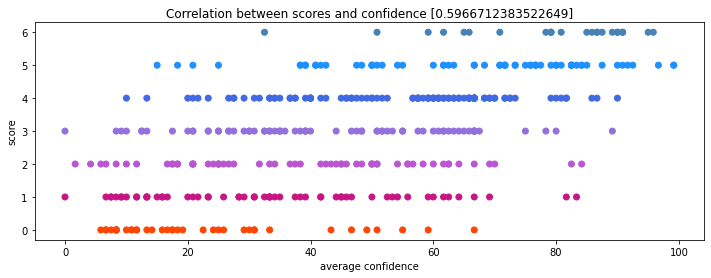

In [46]:
def plot_confidence_score_scatter(df):
    plt.figure(figsize=(12, 4))
    y = df['q1_score'] + df['q2_score'] + df['q3_score'] + df['q4_score'] + df['q5_score'] + df['q6_score']
    df['plot_confidence'] = df['q1_conf'].astype(int) + df['q2_conf'].astype(int) + df['q3_conf'].astype(int) + df['q4_conf'].astype(int) + df['q5_colour1'].astype(int) + df['q6_colour1'].astype(int)
    x = df['plot_confidence'].apply(lambda x: float(x)/6)
    
    colour_keys = list(palette.keys())
    colours = [palette[colour_keys[score]] for score in df['plot_score']]
    
    plt.scatter(y=y, x=x, color=colours)
    
    plt.xlabel('average confidence')
    plt.ylabel('score')
    plt.title('Correlation between scores and confidence [' + str(np.corrcoef(x, y)[0, 1]) + ']')
    plt.show()

plot_confidence_score_scatter(ranks)